# Assignment: Video Quality Inference

To this point in the class, you have learned various techniques for leading and analyzing packet captures of various types, generating features from those packet captures, and training and evaluating models using those features.

In this assignment, you will put all of this together, using a network traffic trace to train a model to automatically infer video quality of experience from a labeled traffic trace.

## Part 1: Warmup

The first part of this assignment builds directly on the hands-on activities but extends them slightly.

### Extract Features from the Network Traffic

Load the `netflix.pcap` file, which is a packet trace that includes network traffic. 

Click [here](https://github.com/noise-lab/ml-systems/blob/main/docs/notebooks/data/netflix.pcap) to download `netflix.pcap`.


In [277]:
# Import pcap file into a Pandas DataFrame

from scapy.all import rdpcap, IP, TCP, UDP, DNS
import pandas as pd

pkts = rdpcap("netflix.pcap")  # may use lots of RAM for big files
rows = []
for p in pkts:
    is_dns = DNS in p
    proto = "DNS" if is_dns else ("TCP" if TCP in p else ("UDP" if UDP in p else p.name))
    txid = p[DNS].id if is_dns else None
    rows.append({
        "timestamp": float(getattr(p, "time", None)),
        "length": len(p),
        "src_ip": p[IP].src if IP in p else None,
        "dst_ip": p[IP].dst if IP in p else None,
        "protocol": proto,
        "src_port": p[TCP].sport if TCP in p else (p[UDP].sport if UDP in p else None),
        "dst_port": p[TCP].dport if TCP in p else (p[UDP].dport if UDP in p else None),
        "txid": txid,
        "info": str(p.summary())
    })

pcap_import = pd.DataFrame(rows)

In [278]:
pcap_import.head()

,timestamp,length,src_ip,dst_ip,protocol,src_port,dst_port,txid,info
0,1518358200.53468,77,192.168.43.72,128.93.77.234,DNS,55697.00000,53.00000,60684.00000,"Ether / IP / UDP / DNS Qry ""b'fonts.gstatic.co..."
1,1518358200.53483,77,192.168.43.72,128.93.77.234,DNS,59884.00000,53.00000,12314.00000,"Ether / IP / UDP / DNS Qry ""b'fonts.gstatic.co..."
2,1518358200.53941,87,192.168.43.72,128.93.77.234,DNS,61223.00000,53.00000,4563.00000,"Ether / IP / UDP / DNS Qry ""b'googleads.g.doub..."
3,1518358200.54120,87,192.168.43.72,128.93.77.234,DNS,58785.00000,53.00000,4740.00000,"Ether / IP / UDP / DNS Qry ""b'googleads.g.doub..."
4,1518358200.54578,78,192.168.43.72,128.93.77.234,DNS,51938.00000,53.00000,13362.00000,"Ether / IP / UDP / DNS Qry ""b'ytimg.l.google.c..."


### Identifying the Service Type

Use the DNS traffic to filter the packet trace for Netflix traffic.

In [279]:
# Get transaction IDs from Netflix DNS queries

nflx_queries = pcap_import[pcap_import["info"].str.contains(r"netflix|nflx", na=False) &
                           pcap_import["info"].str.contains(r"Qry", na=False)]

nflx_txids = [int(x) for x in nflx_queries["txid"].unique().tolist()]

In [280]:
print(nflx_txids)

[45466, 12361, 24416, 7939, 30582, 14313, 37909, 26231, 48727, 21826, 9887, 33001, 49332, 14721, 33500, 34542, 60735, 43441]


In [281]:
# Get Netflix DNS answers by matching txids

nflx_answers = pcap_import[pcap_import["txid"].isin(nflx_txids) & 
                           pcap_import["protocol"].eq("DNS") & 
                           pcap_import["info"].str.contains(r"Ans", na=False)]

nflx_answers.head(10)

,timestamp,length,src_ip,dst_ip,protocol,src_port,dst_port,txid,info
101,1518358202.90277,109,128.93.77.234,192.168.43.72,DNS,53.00000,48058.00000,30582.00000,"Ether / IP / UDP / DNS Ans ""198.38.120.130"""
102,1518358202.90278,102,128.93.77.234,192.168.43.72,DNS,53.00000,43209.00000,45466.00000,"Ether / IP / UDP / DNS Ans ""52.19.39.146"""
103,1518358202.90281,113,128.93.77.234,192.168.43.72,DNS,53.00000,4046.00000,7939.00000,"Ether / IP / UDP / DNS Ans ""52.210.19.176"""
104,1518358202.90283,109,128.93.77.234,192.168.43.72,DNS,53.00000,50901.00000,14313.00000,"Ether / IP / UDP / DNS Ans ""198.38.120.153"""
105,1518358202.90286,96,128.93.77.234,192.168.43.72,DNS,53.00000,28162.00000,12361.00000,"Ether / IP / UDP / DNS Ans ""23.57.80.120"""
108,1518358202.90331,96,128.93.77.234,192.168.43.72,DNS,53.00000,48245.00000,24416.00000,"Ether / IP / UDP / DNS Ans ""23.57.80.120"""
219,1518358203.64291,94,128.93.77.234,192.168.43.72,DNS,53.00000,57216.00000,26231.00000,"Ether / IP / UDP / DNS Ans ""198.38.120.137"""
224,1518358203.65937,96,128.93.77.234,192.168.43.72,DNS,53.00000,55348.00000,48727.00000,"Ether / IP / UDP / DNS Ans ""23.57.80.120"""
228,1518358203.67025,109,128.93.77.234,192.168.43.72,DNS,53.00000,15562.00000,37909.00000,"Ether / IP / UDP / DNS Ans ""198.38.120.167"""
1019,1518358212.32345,108,128.93.77.234,192.168.43.72,DNS,53.00000,36897.00000,21826.00000,"Ether / IP / UDP / DNS Ans ""34.252.77.54"""


In [282]:
# Get Netflix IPs

nflx_ips = set()
for info in nflx_answers["info"]:
  parts = info.split("\"")
  for part in parts:
    if part.count(".") == 3:  # crude check for IPv4 address
      nflx_ips.add(part)

print(nflx_ips)

{'198.38.120.167', '198.38.120.166', '52.210.133.255', '198.38.120.134', '52.48.148.78', '52.48.8.150', '198.38.120.153', '23.57.80.120', '52.19.39.146', '198.38.120.162', '52.208.128.101', '198.38.120.130', '52.210.19.176', '198.38.120.137', '34.252.77.54', '198.38.120.164'}


In [283]:
# Get all Netflix packet by IP address

nflx_pkts = pcap_import[(pcap_import["src_ip"].isin(nflx_ips)) | (pcap_import["dst_ip"].isin(nflx_ips))].copy()

nflx_pkts.head(10)

,timestamp,length,src_ip,dst_ip,protocol,src_port,dst_port,txid,info
107,1518358202.90327,78,192.168.43.72,198.38.120.130,TCP,58451.00000,443.00000,NaN,Ether / IP / TCP 192.168.43.72:58451 > 198.38....
109,1518358202.90332,78,192.168.43.72,198.38.120.130,TCP,58452.00000,443.00000,NaN,Ether / IP / TCP 192.168.43.72:58452 > 198.38....
110,1518358202.90341,78,192.168.43.72,198.38.120.130,TCP,58453.00000,443.00000,NaN,Ether / IP / TCP 192.168.43.72:58453 > 198.38....
112,1518358202.90363,78,192.168.43.72,52.19.39.146,TCP,58454.00000,443.00000,NaN,Ether / IP / TCP 192.168.43.72:58454 > 52.19.3...
113,1518358202.90369,78,192.168.43.72,52.19.39.146,TCP,58455.00000,443.00000,NaN,Ether / IP / TCP 192.168.43.72:58455 > 52.19.3...
114,1518358202.90377,78,192.168.43.72,52.19.39.146,TCP,58456.00000,443.00000,NaN,Ether / IP / TCP 192.168.43.72:58456 > 52.19.3...
115,1518358202.90381,78,192.168.43.72,52.19.39.146,TCP,58457.00000,443.00000,NaN,Ether / IP / TCP 192.168.43.72:58457 > 52.19.3...
116,1518358202.90394,78,192.168.43.72,52.19.39.146,TCP,58458.00000,443.00000,NaN,Ether / IP / TCP 192.168.43.72:58458 > 52.19.3...
117,1518358202.90397,78,192.168.43.72,52.19.39.146,TCP,58459.00000,443.00000,NaN,Ether / IP / TCP 192.168.43.72:58459 > 52.19.3...
119,1518358202.90421,78,192.168.43.72,52.210.19.176,TCP,58460.00000,443.00000,NaN,Ether / IP / TCP 192.168.43.72:58460 > 52.210....


### Generate Statistics

Generate statistics and features for the Netflix traffic flows. Use the `netml` library or any other technique that you choose to generate a set of features that you think would be good features for your model. 

In [284]:
import numpy as np
# filter for tcp, udp traffic only
# group by 10 second windows - 
# num packets, total bytes, mean packet size, IAT, 
# max min packet size, num unique dst ips

df = nflx_pkts.copy()
df = df[df["protocol"].fillna("").str.lower().isin(["tcp", "udp"])].reset_index(drop=True)

# ensure timestamp and length numeric
df["timestamp"] = df["timestamp"].astype(float)
df["length"] = df["length"].astype(int)

# compute 10-second time window (align to multiples of 10)
df["time_window"] = (np.floor(df["timestamp"] / 10) * 10).astype(int)

# compute inter-arrival time within each time window
df["iat_within_window"] = df.groupby("time_window")["timestamp"].diff()

# aggregate per time window
nflx_windows = df.groupby("time_window").agg(
    packet_count=("length", "size"),
    total_bytes=("length", "sum"),
    mean_pkt_size=("length", "mean"),
    max_pkt_size=("length", "max"),
    min_pkt_size=("length", "min"),
    mean_iat=("iat_within_window", "mean"),
    unique_dst_ips=("dst_ip", "nunique"),
).reset_index()

# merge aggregated features back into nflx_pkts
nflx_pkts = df.merge(nflx_windows, on="time_window", how="left")

# show result
print("Per-window summary rows:", len(nflx_windows))
display(nflx_windows.head())

Per-window summary rows: 50


,time_window,packet_count,total_bytes,mean_pkt_size,max_pkt_size,min_pkt_size,mean_iat,unique_dst_ips
0,1518358200,679,80019,117.84831,200,66,0.01045,8
1,1518358210,494,63930,129.41296,200,54,0.02010,8
2,1518358220,614,80536,131.16612,200,54,0.01620,10
3,1518358230,509,72511,142.45776,200,66,0.01900,4
4,1518358240,388,56428,145.43299,200,66,0.02480,4


**Write a brief justification for the features that you have chosen.**

### Inferring Segment downloads

In addition to the features that you could generate using the `netml` library or similar, add to your feature vector a "segment downloads rate" feature, which indicates the number of video segments downloaded for a given time window.

Note: If you are using the `netml` library, generating features with `SAMP` style options may be useful, as this option gives you time windows, and you can then simply add the segment download rate to that existing dataframe.

In [285]:

segment_download_rate = nflx_pkts.groupby("time_window").size().reset_index(name="segment_download_rate")
nflx_windows = nflx_windows.merge(segment_download_rate, on="time_window", how="left")
nflx_windows["segment_download_rate"] = nflx_windows["segment_download_rate"].fillna(0).astype(int)

# show result
print("Per-window summary rows:", len(nflx_windows))
display(nflx_windows.head())

Per-window summary rows: 50


,time_window,packet_count,total_bytes,mean_pkt_size,max_pkt_size,min_pkt_size,mean_iat,unique_dst_ips,segment_download_rate
0,1518358200,679,80019,117.84831,200,66,0.01045,8,679
1,1518358210,494,63930,129.41296,200,54,0.02010,8,494
2,1518358220,614,80536,131.16612,200,54,0.01620,10,614
3,1518358230,509,72511,142.45776,200,66,0.01900,4,509
4,1518358240,388,56428,145.43299,200,66,0.02480,4,388


## Part 2: Video Quality Inference

You will now load the complete video dataset from a previous study to train and test models based on these features to automatically infer the quality of a streaming video flow.

For this part of the assignment, you will need two pickle files, which we provide for you by running the code below:

```

!gdown 'https://drive.google.com/uc?id=1N-Cf4dJ3fpak_AWgO05Fopq_XPYLVqdS' -O netflix_session.pkl
!gdown 'https://drive.google.com/uc?id=1PHvEID7My6VZXZveCpQYy3lMo9RvMNTI' -O video_dataset.pkl

```

### Load the File

Load the video dataset pickle file.

In [299]:
netflix_video = pd.read_pickle("/Users/hudsoncarpenter/Downloads/netflix_dataset.pkl")

### Clean the File

1. The dataset contains video resolutions that are not valid. Remove entries in the dataset that do not contain a valid video resolution. Valid resolutions are 240, 360, 480, 720, 1080.

In [300]:
valid_res = {240, 360, 480, 720, 1080}
netflix_video = netflix_video[netflix_video["resolution"].isin(valid_res)]

2. The file also contains columns that are unnecessary (in fact, unhelpful!) for performing predictions. Identify those columns, and remove them.

In [301]:
# remove columns with same values
# remove columns with NAs
# find columns that are repeats of other columns (ending in R)
# only keep numeric columns
# remove nested structures
# 251 - 39 total cols = 213

from pandas.api import types as ptypes

df = netflix_video.copy()

# 1 Drop columns that contain any NaN
df = df.dropna(axis=1)

# 2 Remove columns with nested/unhashable values
def is_scalar_series(s):
    # Try to detect columns that contain lists, dicts, arrays, or tuples
    try:
        sample = s.head(100)
        for x in sample:
            if isinstance(x, (list, dict, set, tuple, np.ndarray)):
                return False
        return True
    except Exception:
        return False

scalar_cols = [c for c in df.columns if is_scalar_series(df[c])]
df = df[scalar_cols]

# 3 Remove columns with constant value
nunique = df.nunique(dropna=False)
df = df.loc[:, nunique > 1]

# 4 Remove duplicate columns
df = df.loc[:, ~df.T.duplicated()]

# 5 Remove non-numeric columns
df = df.select_dtypes(include='number')

netflix_video_clean = df.copy()

# show resulting dataframe shape and head
print("Resulting shape:", netflix_video_clean.shape)
display(netflix_video_clean.head())

Resulting shape: (49748, 206)


,10_avg_chunksize,10_chunksizes_50,10_chunksizes_75,10_chunksizes_85,10_chunksizes_85R,10_chunksizes_90,10_chunksizes_90R,10_max_chunksize,10_min_chunksize,10_std_chunksize,...,userStdInterArrivalTime,userStdRTT,userStdRetransmit,userStdRwnd,userStrBytesInFlight,userSynFlags,userTwoRetransmit,userXRetransmit,userZeroRetransmit,startup_mc
208,148947.10000,43473.00000,185098.00000,361832.30000,361832.30000,461040.20000,461040.20000,539882,4380,185126.04220,...,287.44077,19684.62482,57.46284,985.13646,0,4,0.00000,0.10873,0.55794,12.00000
209,91984.20000,101882.00000,122323.00000,159843.40000,159843.40000,181011.80000,181011.80000,196778,24498,62449.10736,...,258.30904,8183.94228,71.01178,310.12315,0,1,0.00000,0.11687,0.54980,12.00000
210,147725.00000,111373.00000,224157.00000,286280.00000,286280.00000,325845.80000,325845.80000,396800,24498,134268.55972,...,228.91286,7087.84922,85.19880,149.66943,0,0,0.00000,0.12685,0.53981,12.00000
211,246420.60000,297522.00000,330737.50000,361030.70000,361030.70000,378404.00000,378404.00000,396800,24498,127394.37245,...,239.76849,56963.44579,109.39705,14006.71365,0,1,0.00000,0.18611,0.48056,12.00000
212,336681.00000,354461.00000,399719.50000,409866.30000,409866.30000,414060.00000,414060.00000,438000,198238,79844.36800,...,1789.02671,10988.57944,122.13290,13261.30582,0,0,0.00000,0.19444,0.47222,12.00000


**Briefly explain why you removed those columns.**

### Prepare Your Data

Prepare your data matrix, determine your features and labels, and perform a train-test split on your data.

In [302]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# prepare features and labels
y = netflix_video_clean["resolution"].astype('category').cat.codes # labels
x = netflix_video_clean.drop(columns=["resolution"]) # features

x_train, x_test, y_train, y_test = train_test_split(
  x, y,
  test_size=0.3, 
  random_state=42
  # stratify=y
)

 # Standardize features for classification model
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

### Train and Tune Your Model

1. Select a model of your choice.
2. Train the model using your training data.

In [303]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression

# Train a logistic regression classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(x_train_scaled, y_train)

# Predictions
y_pred = clf.predict(x_test_scaled)
y_pred_prob = clf.predict_proba(x_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R² Score:", r2)

Mean Squared Error (MSE): 0.2738358458961474
R² Score: 0.631199972159134


### Tune Your Model

Perform hyperparameter tuning to find optimal parameters for your model.

In [291]:
from sklearn.pipeline import Pipeline
# from sklearn.model_selection import RandomizedSearchCV

# # create a pipeline for scaling + model
# pipe = Pipeline([
#     ('scaler', StandardScaler()),
#     ('logreg', LogisticRegression(max_iter=10000))
# ])

# # define hyperparameter grid
# param_grid = {
#     'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],  # regularization strength (inverse of lambda)
#     'logreg__penalty': ['l2'],
#     'logreg__solver': ['liblinear'],      # solvers supporting both L1 and L2
#     'logreg__class_weight': [None, 'balanced']    # handle class imbalance
# }

# # perform grid search
# grid = RandomizedSearchCV(pipe, param_grid, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
# grid.fit(x_train_scaled, y_train)

# print("Best Parameters:", grid.best_params_)
# print("Best CV Accuracy:", grid.best_score_)

# Rebuild tuned model pipeline with best params
# 3 minute run time
final_model = Pipeline([
    ('logreg', LogisticRegression(
        solver='liblinear',
        penalty='l2',
        C=100,
        class_weight=None,
        max_iter=10000
    ))
])

# Train tuned model on full training set
final_model.fit(x_train_scaled, y_train)

Pipeline(steps=[('logreg',
                 LogisticRegression(C=100, max_iter=10000,
                                    solver='liblinear'))])

### Evaluate Your Model

Evaluate your model accuracy according to the following metrics:

1. Accuracy
2. F1 Score
3. Confusion Matrix
4. ROC/AUC

In [295]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

y_pred_final = final_model.predict(x_test_scaled)
y_proba_final = final_model.predict_proba(x_test_scaled)

acc = accuracy_score(y_test, y_pred_final)
f1 = f1_score(y_test, y_pred_final, average='weighted')
cm = confusion_matrix(y_test, y_pred_final)
try:
    auc = roc_auc_score(y_test, y_proba_final, multi_class='ovr')
except ValueError:
    auc = None
r2 = r2_score(y_test, y_pred_final)

print("Accuracy:", acc)
print("F1 Score:", f1)
print("ROC-AUC:", auc)
print("Confusion Matrix:\n", cm)
print(f"R² Score: {r2:.4f}")

Accuracy: 0.8038860971524288
F1 Score: 0.7887490122733355
ROC-AUC: 0.9349192577716071
Confusion Matrix:
 [[ 233   53  193   35    1]
 [  44  887  394   24    0]
 [  59  179 8263  345    8]
 [  18   20 1430 1244  109]
 [   0    1    5    9 1371]]
R² Score: 0.6119


## Part 3: Predict the Ongoing Resolution of a Real Netflix Session

Now that you have your model, it's time to put it in practice!

Use a preprocessed Netflix video session to infer **and plot** the resolution at 10-second time intervals.

In [309]:
print(netflix_video_clean.columns.tolist())
print(netflix_video_clean['relative_timestamp'].head(1000000))

['10_avg_chunksize', '10_chunksizes_50', '10_chunksizes_75', '10_chunksizes_85', '10_chunksizes_85R', '10_chunksizes_90', '10_chunksizes_90R', '10_max_chunksize', '10_min_chunksize', '10_std_chunksize', 'absolute_timestamp', 'access_50_perc', 'access_75_perc', 'access_avg', 'access_max', 'access_min', 'access_stddev', 'access_var', 'all_prev_down_chunk_iat_50', 'all_prev_down_chunk_iat_75', 'all_prev_down_chunk_iat_85', 'all_prev_down_chunk_iat_85R', 'all_prev_down_chunk_iat_90', 'all_prev_down_chunk_iat_90R', 'all_prev_down_chunk_iat_avg', 'all_prev_down_chunk_iat_max', 'all_prev_down_chunk_iat_min', 'all_prev_down_chunk_iat_std', 'all_prev_up_chunk_iat_50', 'all_prev_up_chunk_iat_75', 'all_prev_up_chunk_iat_85', 'all_prev_up_chunk_iat_85R', 'all_prev_up_chunk_iat_90', 'all_prev_up_chunk_iat_90R', 'all_prev_up_chunk_iat_avg', 'all_prev_up_chunk_iat_max', 'all_prev_up_chunk_iat_min', 'all_prev_up_chunk_iat_std', 'allprev_avg_chunksize', 'allprev_chunksizes_50', 'allprev_chunksizes_75',

Full Dataset Accuracy: 0.8042


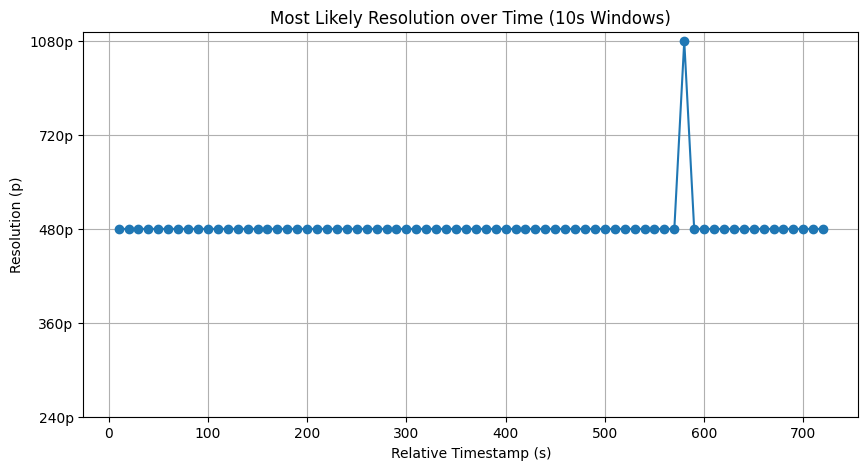

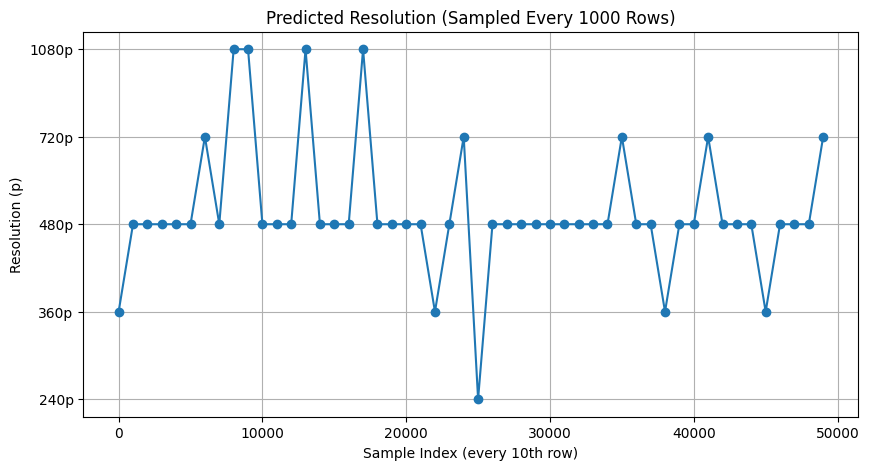

In [ ]:
import matplotlib.pyplot as plt

# 1️⃣ Separate features and labels again
y_full = netflix_video_clean["resolution"].astype('category').cat.codes
x_full = netflix_video_clean.drop(columns=["resolution"])

# 2️⃣ Scale full dataset using the same scaler
x_full_scaled = scaler.transform(x_full)

# 3️⃣ Apply the trained final model
y_full_pred = final_model.predict(x_full_scaled)

netflix_video_results = netflix_video_clean.sort_values("relative_timestamp")
netflix_video_results['predicted_resolution'] = y_full_pred

# Optional: evaluate overall performance on full dataset
acc_full = accuracy_score(y_full, y_full_pred)
print(f"Full Dataset Accuracy: {acc_full:.4f}")

# Plot most frequent resolution over time -------------------------------------
# Plot the dominant resolution per 10s interval
df = netflix_video_results.copy()
df = df.sort_values('relative_timestamp').reset_index(drop=True)

# Define time window size (10 seconds)
window_size = 10

# Assign each timestamp to a time window
df['time_group'] = (df['relative_timestamp'] // window_size).astype(int)

# Compute mode predicted_resolution per 10-second window
grouped = (
    df.groupby('time_group')
    .agg({
        'relative_timestamp': 'mean',
        'predicted_resolution': lambda x: x.mode().iloc[0] if not x.mode().empty else None
    })
)

# Map numeric codes to resolution labels
resolution_map = {
    0: '240p',
    1: '360p',
    2: '480p',
    3: '720p',
    4: '1080p'
}
grouped['predicted_resolution_label'] = grouped['predicted_resolution'].map(resolution_map)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(
    grouped['relative_timestamp'],
    grouped['predicted_resolution'],
    marker='o', linestyle='-'
)
plt.xlabel('Relative Timestamp (s)')
plt.ylabel('Resolution (p)')
plt.title('Most Likely Resolution over Time (10s Windows)')
plt.yticks(list(resolution_map.keys()), list(resolution_map.values()))
plt.grid(True)
plt.show()


# Plot every 1000 rows ------------------------------------------------------
# Copy and reset index
df = netflix_video_results.copy().reset_index(drop=True)

# Take every 1000th row
df_sampled = df.iloc[::1000, :]

# Map numeric codes to resolution labels
resolution_map = {
    0: '240p',
    1: '360p',
    2: '480p',
    3: '720p',
    4: '1080p'
}

plt.figure(figsize=(10, 5))
plt.plot(df_sampled.index, df_sampled['predicted_resolution'], marker='o', linestyle='-')
plt.xlabel('Sample Index (every 10th row)')
plt.ylabel('Resolution (p)')
plt.title('Predicted Resolution (Sampled Every 1000 Rows)')
plt.yticks(list(resolution_map.keys()), list(resolution_map.values()))
plt.grid(True)
plt.show()
